In [1]:
#Step 1 - Import necessary libraries
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
#Step 2 = Replace these paths with the actual paths to your CSV files in Google Drive

transaction_path = r'C:\Users\DELL\Downloads\Transaction_Data.csv'
productoffering_path = r'C:\Users\DELL\Downloads\Product_Offering_Data.csv'
customerfeedback_path = r'C:\Users\DELL\Downloads\Customer_Feedback_Data.csv'


# Load the datasets
transaction_df = pd.read_csv(transaction_path)
productoffering_df = pd.read_csv(productoffering_path) 
customerfeedback_df = pd.read_csv(customerfeedback_path)

In [15]:
#Step 3 - Frequency counts and dataset summaries

# --- Total number of rows (excluding header) ---
total_rows = len(transaction_df)
print(f"\nTotal number of rows in Transaction_Data dataset (excluding header): {total_rows}")

total_rows = len(productoffering_df)
print(f"\nTotal number of rows in Product_Offering_Data dataset (excluding header): {total_rows}")

total_rows = len(customerfeedback_df)
print(f"\nTotal number of rows in Customer_Feedback_Data dataset (excluding header): {total_rows}")

# --- Total number of columns ---
total_columns = transaction_df.shape[1]
print(f"Total number of columns in Transaction_Data dataset: {total_columns}")

total_columns = productoffering_df.shape[1]
print(f"Total number of columns in Product_Offering_Data dataset: {total_columns}")

total_columns = customerfeedback_df.shape[1]
print(f"Total number of columns in Customer_Feedback_Data dataset: {total_columns}")


Total number of rows in Transaction_Data dataset (excluding header): 5050

Total number of rows in Product_Offering_Data dataset (excluding header): 15

Total number of rows in Customer_Feedback_Data dataset (excluding header): 5050
Total number of columns in Transaction_Data dataset: 5
Total number of columns in Product_Offering_Data dataset: 6
Total number of columns in Customer_Feedback_Data dataset: 4


In [23]:
#Step 4 - Check datasets info
print("\nTransaction Data Info:")
transaction_df.info()

print("\nProduct Offering Data Info:")
productoffering_df.info()

print("\nCustomer Feedback Data Info:")
customerfeedback_df.info()

# =====================================================
# Step 4b – Fix data types needed for feature engineering
# =====================================================

# Convert Transaction_Date to datetime so .dt works
transaction_df['Transaction_Date'] = pd.to_datetime(
    transaction_df['Transaction_Date'],
    errors='coerce'
)

# Optional: check how many became NaT (invalid dates)
print("Missing/invalid Transaction_Date after conversion:",
      transaction_df['Transaction_Date'].isna().sum())



Transaction Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Transaction_ID      5050 non-null   int64  
 1   Customer_ID         5050 non-null   int64  
 2   Transaction_Date    5050 non-null   object 
 3   Transaction_Amount  4950 non-null   float64
 4   Transaction_Type    5050 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 197.4+ KB

Product Offering Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Product_ID           15 non-null     int64  
 1   Product_Name         15 non-null     object 
 2   Product_Type         15 non-null     object 
 3   Risk_Level           15 non-null     object 
 4   Target_Age_Group     0 non-

In [72]:
# =====================================================
# Step 5 – Feature Engineering
# =====================================================

# --- Transaction-based features per customer ---

# Total number of transactions per customer
txn_count = transaction_df.groupby('Customer_ID').size().reset_index(
    name='Transaction_Count'
)

# Average transaction amount per customer
avg_txn_value = transaction_df.groupby('Customer_ID')['Transaction_Amount'].mean().reset_index(
    name='Avg_Transaction_Value'
)

# Total transaction amount per customer
total_txn_value = transaction_df.groupby('Customer_ID')['Transaction_Amount'].sum().reset_index(
    name='Total_Transaction_Value'
)

# --- Time-based features ---

transaction_df['Transaction_Month'] = transaction_df['Transaction_Date'].dt.month
transaction_df['Transaction_Weekday'] = transaction_df['Transaction_Date'].dt.dayofweek

# --- Merge engineered features back into customer-level dataset ---

customer_features = txn_count.merge(avg_txn_value, on='Customer_ID', how='left')
customer_features = customer_features.merge(total_txn_value, on='Customer_ID', how='left')

# Optional: fill remaining missing engineered values with 0
customer_features.fillna(0, inplace=True)

customer_features.head()


,Customer_ID,Transaction_Count,Avg_Transaction_Value,Total_Transaction_Value
0,1,6,2799.166667,16795.0
1,2,2,2453.500000,4907.0
2,3,1,1538.000000,1538.0
3,4,2,4147.500000,8295.0
4,5,5,2959.600000,14798.0


Feature Engineering Notes:

Aggregated transaction-level data into customer-level features such as transaction frequency, average transaction value, and total transaction value. These features are designed to support customer segmentation and clustering in Milestone 1 by capturing behavioral intensity and spending patterns.

In [74]:
# =====================================================
# Step 6 – Standardize Transaction_Date (Datetime Only)
# =====================================================

# Convert Transaction_Date to datetime format (keep as datetime for feature engineering)
transaction_df['Transaction_Date'] = pd.to_datetime(
    transaction_df['Transaction_Date'],
    errors='coerce'
)

# Optional sanity check
print("Transaction_Date dtype:", transaction_df['Transaction_Date'].dtype)

# Preview
display(transaction_df[['Transaction_Date']].head())


Transaction_Date dtype: datetime64[ns]


,Transaction_Date
0,2023-01-01 00:00:00
1,2023-01-01 01:00:00
2,2023-01-01 02:00:00
3,2023-01-01 03:00:00
4,2023-01-01 04:00:00


Preprocessing Rationale

Transaction dates were converted to datetime format to enable time-based feature engineering. Aggregated transaction-level data was transformed into customer-level behavioral features to support clustering and customer segmentation in Milestone 1.

In [31]:
#Step 7 - Check and remove duplicates

# -------------------------------
# Transaction_Data
# -------------------------------
# --- 1. Number of unique Transaction IDs ---
unique_txn_ids = transaction_df['Transaction_ID'].nunique()
print(f"Number of unique Transaction_IDs: {unique_txn_ids}")

# --- 2. Count duplicate Transaction IDs ---
duplicate_txn_count = transaction_df.duplicated(subset=['Transaction_ID']).sum()
print(f"Number of duplicate Transaction_ID entries: {duplicate_txn_count}")

# --- 3. View the duplicate records ---
duplicate_transactions = transaction_df[
    transaction_df.duplicated(subset=['Transaction_ID'], keep=False)
].sort_values(by='Transaction_ID')

display(duplicate_transactions)

# --- 4. Drop duplicate Transaction_ID rows (keep first occurrence) ---
transaction_df = transaction_df.drop_duplicates(subset=['Transaction_ID'])

# --- 5. Re-check counts after dropping duplicates ---
unique_txn_ids_after = transaction_df['Transaction_ID'].nunique()
print(f"Number of unique Transaction_IDs after dropping duplicates: {unique_txn_ids_after}")

duplicate_txn_count_after = transaction_df.duplicated(subset=['Transaction_ID']).sum()
print(f"Number of duplicate Transaction_ID entries after dropping duplicates: {duplicate_txn_count_after}")

# --- 6. Confirm total row count ---
print(f"Total rows in Transaction_Data after dropping duplicates: {len(transaction_df)}")


# -------------------------------
# Product Offering Data
# -------------------------------
# --- 1. Check & Remove Full Row Duplicates ---
full_row_duplicates = productoffering_df.duplicated().sum()
print(f"Number of full-row duplicate rows in Product Offering: {full_row_duplicates}")

# --- 2. Remove full-row duplicates ---
productoffering_df = productoffering_df.drop_duplicates()

# --- 3. Verify cleanup ---
print(f"Rows after removing duplicates in Product Offering: {len(productoffering_df)}")

# -------------------------------
# Customer Feedback Data
# -------------------------------
# --- 1. Check & Remove Full Row Duplicates ---
full_row_duplicates = customerfeedback_df.duplicated().sum()
print(f"Number of full-row duplicate rows in Customer Feedback: {full_row_duplicates}")

# --- 2. Remove full-row duplicates ---
customerfeedback_df = customerfeedback_df.drop_duplicates()

# --- 3. Verify cleanup ---
print(f"Rows after removing duplicates in Customer Feedback: {len(customerfeedback_df)}")

Number of unique Transaction_IDs: 5000
Number of duplicate Transaction_ID entries: 50


,Transaction_ID,Customer_ID,Transaction_Date,Transaction_Amount,Transaction_Type,Transaction_Month,Transaction_Weekday
56,57,142,2023-01-03 08:00:00,3791.0,Purchase,1,1
5019,57,142,2023-01-03 08:00:00,3791.0,Purchase,1,1
144,145,456,2023-01-07 00:00:00,4527.0,Loan Payment,1,5
5021,145,456,2023-01-07 00:00:00,4527.0,Loan Payment,1,5
5004,156,474,2023-01-07 11:00:00,1164.0,Loan Payment,1,5
...,...,...,...,...,...,...,...
5008,4558,992,2023-07-09 21:00:00,532.0,Bill Payment,7,6
4741,4742,757,2023-07-17 13:00:00,386.0,Investment,7,0
5033,4742,757,2023-07-17 13:00:00,386.0,Investment,7,0
5001,4971,463,2023-07-27 02:00:00,3123.0,Loan Payment,7,3


Number of unique Transaction_IDs after dropping duplicates: 5000
Number of duplicate Transaction_ID entries after dropping duplicates: 0
Total rows in Transaction_Data after dropping duplicates: 5000
Number of full-row duplicate rows in Product Offering: 5
Rows after removing duplicates in Product Offering: 10
Number of full-row duplicate rows in Customer Feedback: 81
Rows after removing duplicates in Customer Feedback: 4969


In [ ]:
#Step 8 - Count missing values per column in each dataset
# --- Transaction_Data ---
missing_transactions = transaction_df.isna().sum()
print("Missing values in transaction_df:")
print(missing_transactions)
print("\n")

# --- Product_Offering_Data ---
missing_productoffering = productoffering_df.isna().sum()
print("Missing values in productoffering_df:")
print(missing_productoffering)
print("\n")

# --- Customer_Feedback_Data ---
missing_customerfeedback = customerfeedback_df.isna().sum()
print("Missing values in customerfeedback_df:")
print(missing_customerfeedback)
print("\n")

Missing values in transaction_df:
Transaction_ID          0
Customer_ID             0
Transaction_Date        0
Transaction_Amount    100
Transaction_Type        0
dtype: int64


Missing values in productoffering_df:
Product_ID              0
Product_Name            0
Product_Type            0
Risk_Level              0
Target_Age_Group       10
Target_Income_Group     0
dtype: int64


Missing values in customerfeedback_df:
Customer_ID                  0
Satisfaction_Score         100
Feedback_Comments            0
Likelihood_to_Recommend      0
dtype: int64




In [33]:
#Step 9 - Drop Target_Age_Group column from Product_Offering_Data dataset

# --- 1. Check columns before dropping ---
print("Columns before dropping Target_Age_Group:")
print(productoffering_df.columns)

# --- 2. Drop the column ---
productoffering_df = productoffering_df.drop(columns=['Target_Age_Group'])

# --- 3. Check columns after dropping ---
print("\nColumns after dropping Target_Age_Group:")
print(productoffering_df.columns)

Columns before dropping Target_Age_Group:
Index(['Product_ID', 'Product_Name', 'Product_Type', 'Risk_Level',
       'Target_Age_Group', 'Target_Income_Group'],
      dtype='object')

Columns after dropping Target_Age_Group:
Index(['Product_ID', 'Product_Name', 'Product_Type', 'Risk_Level',
       'Target_Income_Group'],
      dtype='object')


In [35]:
#Step 10 - Impute missing values in Satisfaction Score using median
# --- 1. Check original number of missing values ---
missing_before = customerfeedback_df['Satisfaction_Score'].isna().sum()
print(f"Missing Satisfaction_Score before imputation: {missing_before}")

# --- 2. Compute median (ignores NaN by default) ---
median_satisfaction = customerfeedback_df['Satisfaction_Score'].median()
print(f"Median Satisfaction_Score used for imputation: {median_satisfaction}")

# --- 3. Impute missing values ---
customerfeedback_df['Satisfaction_Score'] = customerfeedback_df['Satisfaction_Score'].fillna(median_satisfaction)

# --- 4. Verify missing values after imputation ---
missing_after = customerfeedback_df['Satisfaction_Score'].isna().sum()
print(f"Missing Satisfaction_Score after imputation: {missing_after}")

Missing Satisfaction_Score before imputation: 100
Median Satisfaction_Score used for imputation: 6.0
Missing Satisfaction_Score after imputation: 0


In [37]:
#Step 11 - Impute missing Transaction_Amount using median per Customer_ID
  #  Missing Transaction_Amount values were imputed using the median transaction amount of the corresponding customer.
  #  This approach preserves individual customer behavior and prevents bias that could arise from using the overall median across all customers.

# --- 1. Check original number of missing values ---
missing_before = transaction_df['Transaction_Amount'].isna().sum()
print(f"Missing Transaction_Amount before imputation: {missing_before}")

# --- 2. Compute median Transaction_Amount per Customer_ID ---
customer_median = transaction_df.groupby('Customer_ID')['Transaction_Amount'].median()

# --- 3. Fill missing Transaction_Amount using the customer's median (maps each row's Customer_ID to their median) ---
transaction_df['Transaction_Amount'] = transaction_df.apply(
    lambda row: customer_median[row['Customer_ID']]
    if pd.isna(row['Transaction_Amount']) else row['Transaction_Amount'], axis=1
)

# --- 4. Verify missing values after imputation ---
missing_after = transaction_df['Transaction_Amount'].isna().sum()
print(f"Missing Transaction_Amount after imputation: {missing_after}")

Missing Transaction_Amount before imputation: 100
Missing Transaction_Amount after imputation: 0


In [39]:
#Step 12 - Outlier handling

# --- Threshold capping value of 1-10 for Satisfaction Score ---
# --- 1. Save original columns for comparison ---
original_scores = customerfeedback_df['Satisfaction_Score'].copy()
original_txn = transaction_df['Transaction_Amount'].copy()

# --- 2. Threshold capping for Satisfaction_Score ---
print(f"Satisfaction_Score min before capping: {customerfeedback_df['Satisfaction_Score'].min()}")
print(f"Satisfaction_Score max before capping: {customerfeedback_df['Satisfaction_Score'].max()}")

# --- 3. Apply threshold capping ---
customerfeedback_df['Satisfaction_Score'] = customerfeedback_df['Satisfaction_Score'].clip(lower=1, upper=10)

print(f"Satisfaction_Score min after capping: {customerfeedback_df['Satisfaction_Score'].min()}")
print(f"Satisfaction_Score max after capping: {customerfeedback_df['Satisfaction_Score'].max()}")

# --- 4. Count how many values were changed ---
changed_count_scores = (original_scores != customerfeedback_df['Satisfaction_Score']).sum()
print(f"Number of Satisfaction_Score values changed due to capping: {changed_count_scores}")


# --- Winsorization for Transaction_Amount ---
# --- 1. Save original column for comparison ---
original_txn = transaction_df['Transaction_Amount'].copy()

# --- 2. Apply Winsorization and overwrite Transaction_Amount ---
transaction_df['Transaction_Amount'] = winsorize(
    transaction_df['Transaction_Amount'],
    limits=[0.01, 0.01]  # 1% lower, 1% upper
)

# --- 3. Compare statistics before and after ---
print("\nTransaction_Amount stats before Winsorization:")
print(original_txn.describe())
print("\nTransaction_Amount stats after Winsorization:")
print(transaction_df['Transaction_Amount'].describe())

# --- 4. Count how many values were changed ---
changed_count_txn = (original_txn != transaction_df['Transaction_Amount']).sum()
print(f"Number of Transaction_Amount values changed due to Winsorization: {changed_count_txn}")

Satisfaction_Score min before capping: 1.0
Satisfaction_Score max before capping: 60.0
Satisfaction_Score min after capping: 1.0
Satisfaction_Score max after capping: 10.0
Number of Satisfaction_Score values changed due to capping: 10

Transaction_Amount stats before Winsorization:
count      5000.000000
mean       3090.281800
std       14744.386688
min          10.000000
25%        1253.750000
50%        2483.000000
75%        3698.250000
max      480300.000000
Name: Transaction_Amount, dtype: float64

Transaction_Amount stats after Winsorization:
count    5000.000000
mean     2492.338000
std      1433.623105
min        67.000000
25%      1253.750000
50%      2483.000000
75%      3698.250000
max      4952.000000
Name: Transaction_Amount, dtype: float64
Number of Transaction_Amount values changed due to Winsorization: 100


C:\Users\DELL\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


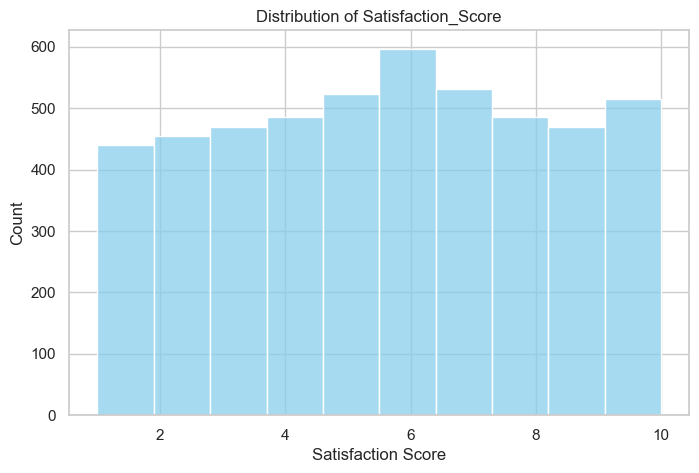

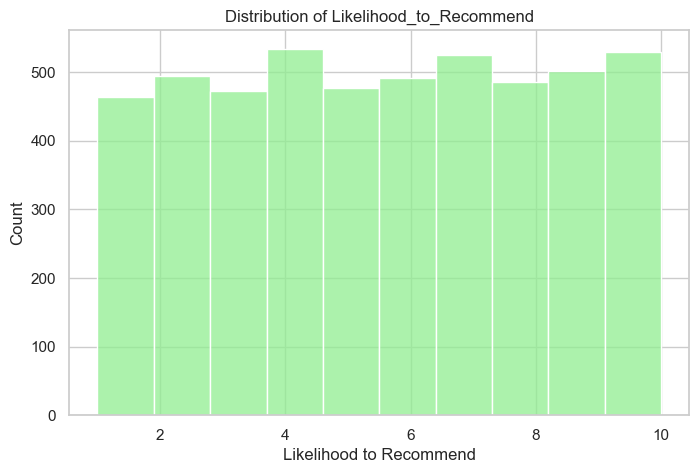

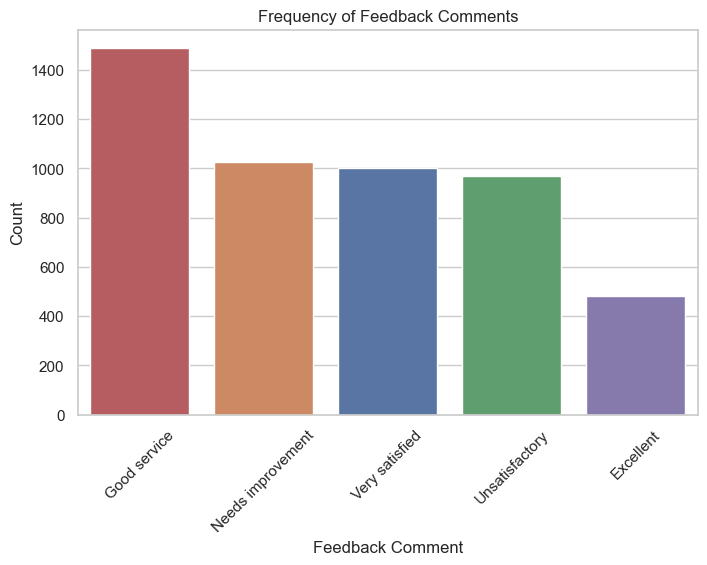

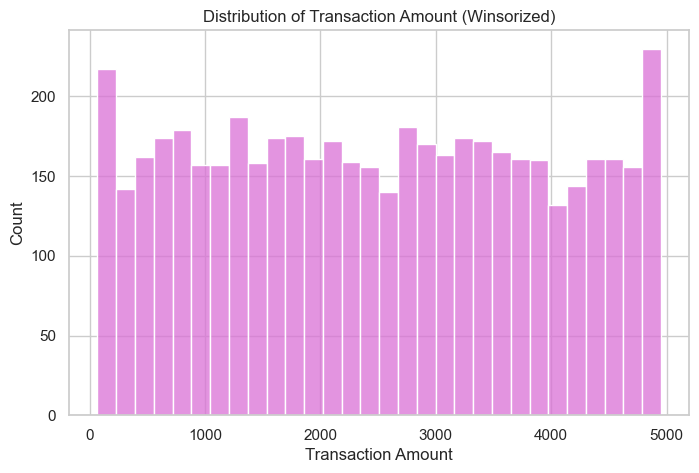

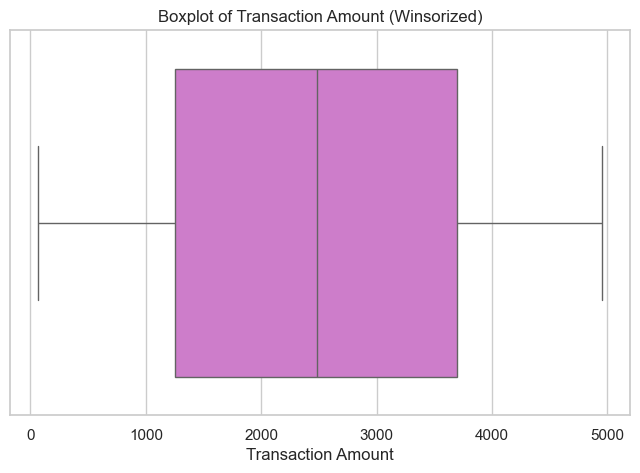

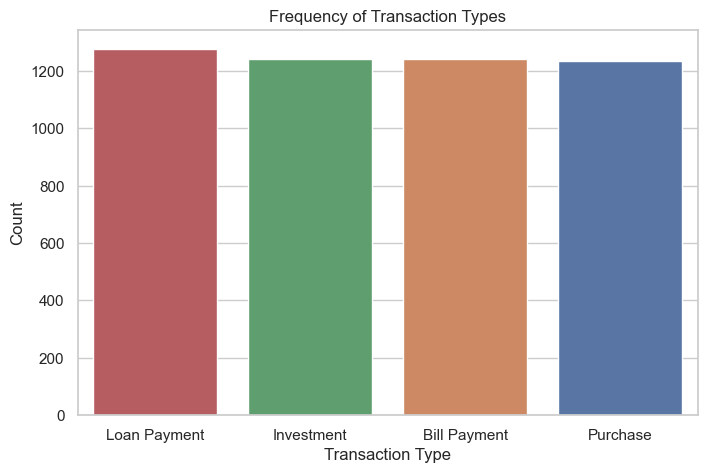

In [44]:
#Step 13 - Set distribution plots
sns.set(style="whitegrid")

# -------------------------------
# Customer_Feedback_Data Plots
# -------------------------------

# 1. Satisfaction_Score distribution
plt.figure(figsize=(8,5))
sns.histplot(customerfeedback_df['Satisfaction_Score'], bins=10, kde=False, color='skyblue')
plt.title('Distribution of Satisfaction_Score')
plt.xlabel('Satisfaction Score')
plt.ylabel('Count')
plt.show()

# 2. Likelihood_to_Recommend distribution
plt.figure(figsize=(8,5))
sns.histplot(customerfeedback_df['Likelihood_to_Recommend'], bins=10, kde=False, color='lightgreen')
plt.title('Distribution of Likelihood_to_Recommend')
plt.xlabel('Likelihood to Recommend')
plt.ylabel('Count')
plt.show()

# 3. Feedback_Comments word count distribution (optional numeric proxy)
plt.figure(figsize=(8,5))
sns.countplot(
    data=customerfeedback_df,
    x='Feedback_Comments',
    order=customerfeedback_df['Feedback_Comments'].value_counts().index,
    hue='Feedback_Comments',      # Assign x to hue
    dodge=False                    # Keep single bars
)
plt.title('Frequency of Feedback Comments')
plt.xlabel('Feedback Comment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend([],[], frameon=False)   # Remove unnecessary legend
plt.show()

# -------------------------------
# Transaction_Data Plots
# -------------------------------

# 1. Transaction_Amount distribution histogram (after Winsorization)
plt.figure(figsize=(8,5))
sns.histplot(transaction_df['Transaction_Amount'], bins=30, kde=False, color='orchid')
plt.title('Distribution of Transaction Amount (Winsorized)')
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.show()

# 2. Transaction_Amount distribution boxplot (after Winsorization)
plt.figure(figsize=(8,5))
sns.boxplot(x=transaction_df['Transaction_Amount'], color='orchid')
plt.title('Boxplot of Transaction Amount (Winsorized)')
plt.xlabel('Transaction Amount')
plt.show()

# 3. Transaction_Type frequency count
plt.figure(figsize=(8,5))
sns.countplot(
    data=transaction_df,
    x='Transaction_Type',
    order=transaction_df['Transaction_Type'].value_counts().index,
    hue='Transaction_Type',  # satisfy Seaborn's future requirement
    dodge=False               # single bar per category
)
plt.title('Frequency of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.legend([], [], frameon=False)  # remove redundant legend
plt.show()

Feature Engineering Dataset

In [46]:
#Step 14: Create base Customer Profile Dataset with unique Customer_IDs
# Purpose: Key for joining datasets

# --- 1. Get unique Customer_IDs from Transactions and Customer Feedback (in case some customers only exist in feedback) ---
unique_customers = pd.Series(
    pd.concat([transaction_df['Customer_ID'], customerfeedback_df['Customer_ID']]).unique(),
    name='Customer_ID'
)

# --- 2. Create the Customer Profile DataFrame ---
customer_profile_df = pd.DataFrame(unique_customers)

# --- 3. Optional: set Customer_ID as index ---
customer_profile_df.set_index('Customer_ID', inplace=False)

# --- 4. Display the first few rows ---
display(customer_profile_df.head())

,Customer_ID
0,393
1,826
2,916
3,109
4,889


In [48]:
#Step 15: Calculate total_transaction_amount per Customer_ID
# Purpose: Proxy for financial capacity (how much the customer spends overall)

# --- 1. Group transactions by Customer_ID and sum Transaction_Amount ---
total_transaction = transaction_df.groupby('Customer_ID')['Transaction_Amount'].sum().reset_index()

# --- 2. Name the new column total_transaction_amount ---
total_transaction.rename(columns={'Transaction_Amount': 'Total_Transaction_Amount'}, inplace=True)

# --- 3. Merge into the Customer Profile Dataset ---
customer_profile_df = customer_profile_df.merge(total_transaction, on='Customer_ID', how='left')

# --- 4. Display the first few rows ---
display(customer_profile_df.head())

,Customer_ID,Total_Transaction_Amount
0,393,22349.0
1,826,6669.0
2,916,18463.0
3,109,7492.0
4,889,4986.0


In [50]:
#Step 16: Calculate avg_transaction_amount per Customer_ID
# Purpose: Serves as a proxy for typical spending of a customer

# --- 1. Group transactions by Customer_ID and compute mean ---
avg_transaction = transaction_df.groupby('Customer_ID')['Transaction_Amount'].mean().reset_index()

# --- 2. Name the new column ---
avg_transaction.rename(columns={'Transaction_Amount': 'avg_transaction_amount'}, inplace=True)

# --- 3. Merge into the Customer Profile Dataset ---
customer_profile_df = customer_profile_df.merge(avg_transaction, on='Customer_ID', how='left')

# --- 4. Display the first few rows ---
display(customer_profile_df.head())

,Customer_ID,Total_Transaction_Amount,avg_transaction_amount
0,393,22349.0,3192.714286
1,826,6669.0,2223.000000
2,916,18463.0,2051.444444
3,109,7492.0,1498.400000
4,889,4986.0,1662.000000


In [52]:
#Step 17: Count Bill Payment transactions per Customer_ID
# Purpose: Behavioral indicator → Savings Account preference

# --- 1. Count the transaction type ---
bill_payment_count = transaction_df[transaction_df['Transaction_Type'] == 'Bill Payment'] \
    .groupby('Customer_ID')['Transaction_ID'].count().reset_index()

bill_payment_count.rename(columns={'Transaction_ID': 'bill_payment_count'}, inplace=True)

# --- 2. Merge the new column into Customer Profile Dataset ---
customer_profile_df = customer_profile_df.merge(bill_payment_count, on='Customer_ID', how='left')

# --- 3. Fill NaN with 0 for customers with no bill payments ---
customer_profile_df['bill_payment_count'] = customer_profile_df['bill_payment_count'].fillna(0).astype(int)

# --- 4. Display the first few rows ---
display(customer_profile_df.head())

,Customer_ID,Total_Transaction_Amount,avg_transaction_amount,bill_payment_count
0,393,22349.0,3192.714286,3
1,826,6669.0,2223.000000,1
2,916,18463.0,2051.444444,3
3,109,7492.0,1498.400000,1
4,889,4986.0,1662.000000,0


In [54]:
#Step 18: Count Loan Payment transactions per Customer_ID
# Purpose: Behavioral indicator → Loan preference

# --- 1. Count the transaction type ---
loan_payment_count = transaction_df[transaction_df['Transaction_Type'] == 'Loan Payment'] \
    .groupby('Customer_ID')['Transaction_ID'].count().reset_index()

loan_payment_count.rename(columns={'Transaction_ID': 'loan_payment_count'}, inplace=True)

# --- 2. Merge the new column into Customer Profile Dataset ---
customer_profile_df = customer_profile_df.merge(loan_payment_count, on='Customer_ID', how='left')

# --- 3. Fill NaN with 0 for customers with no loan payments ---
customer_profile_df['loan_payment_count'] = customer_profile_df['loan_payment_count'].fillna(0).astype(int)

# --- 4. Display the first few rows ---
display(customer_profile_df.head())

,Customer_ID,Total_Transaction_Amount,avg_transaction_amount,bill_payment_count,loan_payment_count
0,393,22349.0,3192.714286,3,0
1,826,6669.0,2223.000000,1,1
2,916,18463.0,2051.444444,3,3
3,109,7492.0,1498.400000,1,1
4,889,4986.0,1662.000000,0,0


In [56]:
#Step 19: Count Investment transactions per Customer_ID
# Purpose: Behavioral indicator → Investment preference

# --- 1. Count the transaction type ---
investment_count = transaction_df[transaction_df['Transaction_Type'] == 'Investment'] \
    .groupby('Customer_ID')['Transaction_ID'].count().reset_index()

investment_count.rename(columns={'Transaction_ID': 'investment_count'}, inplace=True)

# --- 2. Merge the new column into Customer Profile Dataset ---
customer_profile_df = customer_profile_df.merge(investment_count, on='Customer_ID', how='left')

# --- 3. Fill NaN with 0 for customers with no investment payments ---
customer_profile_df['investment_count'] = customer_profile_df['investment_count'].fillna(0).astype(int)

# --- 4. Display the first few rows ---
display(customer_profile_df.head())

,Customer_ID,Total_Transaction_Amount,avg_transaction_amount,bill_payment_count,loan_payment_count,investment_count
0,393,22349.0,3192.714286,3,0,3
1,826,6669.0,2223.000000,1,1,0
2,916,18463.0,2051.444444,3,3,1
3,109,7492.0,1498.400000,1,1,2
4,889,4986.0,1662.000000,0,0,3


In [58]:
#Step 20: Count Purchase transactions per Customer_ID
# Purpose: Behavioral indicator → Credit Card preference

# --- 1. Count the transaction type ---
purchase_count = transaction_df[transaction_df['Transaction_Type'] == 'Purchase'] \
    .groupby('Customer_ID')['Transaction_ID'].count().reset_index()

purchase_count.rename(columns={'Transaction_ID': 'purchase_count'}, inplace=True)

# --- 2. Merge the new column into Customer Profile Dataset ---
customer_profile_df = customer_profile_df.merge(purchase_count, on='Customer_ID', how='left')

# --- 3. Fill NaN with 0 for customers with no purchase payments ---
customer_profile_df['purchase_count'] = customer_profile_df['purchase_count'].fillna(0).astype(int)

# --- 4. Display the first few rows ---
display(customer_profile_df.head())

,Customer_ID,Total_Transaction_Amount,avg_transaction_amount,bill_payment_count,loan_payment_count,investment_count,purchase_count
0,393,22349.0,3192.714286,3,0,3,1
1,826,6669.0,2223.000000,1,1,0,1
2,916,18463.0,2051.444444,3,3,1,2
3,109,7492.0,1498.400000,1,1,2,1
4,889,4986.0,1662.000000,0,0,3,0


In [60]:
#Step 21: Transaction type ratios
# Purpose: Behavioral indicators → product preference / risk profile

# --- 1. Total transactions per customer ---
customer_profile_df['total_transaction_count'] = (
    customer_profile_df['bill_payment_count'] +
    customer_profile_df['loan_payment_count'] +
    customer_profile_df['investment_count'] +
    customer_profile_df['purchase_count']
)

# --- 2. Calculate ratios ---
customer_profile_df['loan_payment_ratio'] = (customer_profile_df['loan_payment_count'] / customer_profile_df['total_transaction_count']).fillna(0)
customer_profile_df['bill_payment_ratio'] = (customer_profile_df['bill_payment_count'] / customer_profile_df['total_transaction_count']).fillna(0)
customer_profile_df['investment_ratio'] = (customer_profile_df['investment_count'] / customer_profile_df['total_transaction_count']).fillna(0)
customer_profile_df['purchase_ratio'] = (customer_profile_df['purchase_count'] / customer_profile_df['total_transaction_count']).fillna(0)

# --- 3. Display the first few rows ---
display(customer_profile_df[['Customer_ID','loan_payment_ratio','bill_payment_ratio','investment_ratio','purchase_ratio']].head())

,Customer_ID,loan_payment_ratio,bill_payment_ratio,investment_ratio,purchase_ratio
0,393,0.000000,0.428571,0.428571,0.142857
1,826,0.333333,0.333333,0.000000,0.333333
2,916,0.333333,0.333333,0.111111,0.222222
3,109,0.200000,0.200000,0.400000,0.200000
4,889,0.000000,0.000000,1.000000,0.000000


In [62]:
#Step 22: Transaction amount volatility and capacity
# Purpose: Measure spending volatility & financial capacity → risk profile input

# --- 1. Calculate values ---
txn_stats = transaction_df.groupby('Customer_ID')['Transaction_Amount'].agg(
    transaction_amount_std='std',
    max_transaction_amount='max',
    min_transaction_amount='min'
).reset_index()

# --- 2. Merge into customer profile dataset ---
customer_profile_df = customer_profile_df.merge(txn_stats, on='Customer_ID', how='left')

# --- 3. Fill NaN for customers with no transactions ---
customer_profile_df[['transaction_amount_std','max_transaction_amount','min_transaction_amount']] = customer_profile_df[
    ['transaction_amount_std','max_transaction_amount','min_transaction_amount']
].fillna(0)

# --- 4. Display the first few rows ---
display(customer_profile_df[['Customer_ID','transaction_amount_std','max_transaction_amount','min_transaction_amount']].head())

,Customer_ID,transaction_amount_std,max_transaction_amount,min_transaction_amount
0,393,1188.599696,4952.0,1535.0
1,826,1900.000000,4123.0,323.0
2,916,1624.996624,4616.0,67.0
3,109,1996.942989,4549.0,72.0
4,889,131.000000,1793.0,1531.0


In [64]:
#Step 23: High-value transaction ratio
# Purpose: Indicates engagement with high-value transactions → risk & capacity

# --- 1. Count high-value transactions (>4500 as example) ---
high_value_txn = transaction_df[transaction_df['Transaction_Amount'] > 4500].groupby('Customer_ID')['Transaction_ID'].count().reset_index()
high_value_txn.rename(columns={'Transaction_ID': 'high_value_txn_count'}, inplace=True)

# --- 2. Merge into customer profile dataset ---
customer_profile_df = customer_profile_df.merge(high_value_txn, on='Customer_ID', how='left')
customer_profile_df['high_value_txn_count'] = customer_profile_df['high_value_txn_count'].fillna(0)

# --- 3. Calculate ratio ---
customer_profile_df['high_value_txn_ratio'] = (customer_profile_df['high_value_txn_count'] / customer_profile_df['total_transaction_count']).fillna(0)

# --- 4. Display the first few rows ---
display(customer_profile_df[['Customer_ID','high_value_txn_count','high_value_txn_ratio']].head())

,Customer_ID,high_value_txn_count,high_value_txn_ratio
0,393,1.0,0.142857
1,826,0.0,0.000000
2,916,1.0,0.111111
3,109,1.0,0.200000
4,889,0.0,0.000000


In [66]:
#Step 24: Analyze customer feedback-based features

# --- 1. Average satisfaction score ---
# Purpose: Overall satisfaction; high score → likely to adopt / stick with high-value products.
avg_satisfaction_score = customerfeedback_df.groupby('Customer_ID')['Satisfaction_Score'].mean().reset_index()
avg_satisfaction_score.rename(columns={'Satisfaction_Score':'avg_satisfaction_score'}, inplace=True)

# --- 2. Feedback count ---
# Purpose: Customer engagement; more feedback = more active/loyal.
feedback_count = customerfeedback_df.groupby('Customer_ID')['Satisfaction_Score'].count().reset_index()
feedback_count.rename(columns={'Satisfaction_Score':'feedback_count'}, inplace=True)

# --- 3. Satisfaction std (volatility) ---
# Purpose: Consistency of satisfaction; high std → unstable behavior → potential risk for high-value products.
satisfaction_std = customerfeedback_df.groupby('Customer_ID')['Satisfaction_Score'].std().reset_index()
satisfaction_std.rename(columns={'Satisfaction_Score':'satisfaction_std'}, inplace=True)

# --- 4️. Average Likelihood to Recommend ---
# Purpose: Loyalty / willingness to promote products; complements satisfaction score.
avg_ltr = customerfeedback_df.groupby('Customer_ID')['Likelihood_to_Recommend'].mean().reset_index()
avg_ltr.rename(columns={'Likelihood_to_Recommend':'avg_ltr'}, inplace=True)

# --- 5. Merge all feedback features into customer_profile_df ---
customer_profile_df = customer_profile_df.merge(avg_satisfaction_score, on='Customer_ID', how='left')
customer_profile_df = customer_profile_df.merge(feedback_count, on='Customer_ID', how='left')
customer_profile_df = customer_profile_df.merge(satisfaction_std, on='Customer_ID', how='left')
customer_profile_df = customer_profile_df.merge(avg_ltr, on='Customer_ID', how='left')

# --- 6. Fill NaN for customers with no feedback ---
customer_profile_df[['avg_satisfaction_score','feedback_count','satisfaction_std','avg_ltr']] = customer_profile_df[
    ['avg_satisfaction_score','feedback_count','satisfaction_std','avg_ltr']
].fillna(0)

# --- 7. Loyalty flag ---
# Purpose: Quick binary indicator for recommending high-value / high-risk products.
customer_profile_df['loyalty_flag'] = (customer_profile_df['avg_satisfaction_score'] >= 8).astype(int)

# --- 8. Display first few rows ---
display(customer_profile_df.head())

,Customer_ID,Total_Transaction_Amount,avg_transaction_amount,bill_payment_count,loan_payment_count,investment_count,purchase_count,total_transaction_count,loan_payment_ratio,bill_payment_ratio,...,transaction_amount_std,max_transaction_amount,min_transaction_amount,high_value_txn_count,high_value_txn_ratio,avg_satisfaction_score,feedback_count,satisfaction_std,avg_ltr,loyalty_flag
0,393,22349.0,3192.714286,3,0,3,1,7,0.000000,0.428571,...,1188.599696,4952.0,1535.0,1.0,0.142857,1.000000,1,0.000000,3.0,0
1,826,6669.0,2223.000000,1,1,0,1,3,0.333333,0.333333,...,1900.000000,4123.0,323.0,0.0,0.000000,6.166667,6,2.926887,5.5,0
2,916,18463.0,2051.444444,3,3,1,2,9,0.333333,0.333333,...,1624.996624,4616.0,67.0,1.0,0.111111,2.714286,7,2.058663,5.0,0
3,109,7492.0,1498.400000,1,1,2,1,5,0.200000,0.200000,...,1996.942989,4549.0,72.0,1.0,0.200000,3.000000,3,1.000000,7.0,0
4,889,4986.0,1662.000000,0,0,3,0,3,0.000000,0.000000,...,131.000000,1793.0,1531.0,0.0,0.000000,5.000000,5,3.082207,5.6,0


In [68]:
# Step 25: Average feedback sentiment
# Purpose: Quantitative measure of customer satisfaction

# --- 1. Define sentiment mapping ---
sentiment_map = {
    "Excellent": 5,
    "Very satisfied": 4,
    "Good service": 3,
    "Needs improvement": 2,
    "Unsatisfactory": 1
}

# --- 2. Compute average sentiment per customer ---
avg_feedback_sentiment = (
    customerfeedback_df.assign(
        feedback_sentiment_score = customerfeedback_df['Feedback_Comments'].map(sentiment_map)
    )
    .groupby('Customer_ID')['feedback_sentiment_score']
    .mean()
    .reset_index()
    .rename(columns={'feedback_sentiment_score':'avg_feedback_sentiment'})
)

# --- 3. Merge into customer profile dataset ---
customer_profile_df = customer_profile_df.merge(avg_feedback_sentiment, on='Customer_ID', how='left')

# --- 4. Keep NaN for customers with no feedback ---
# Do not fill; NaN reflects inactivity

# --- 5. Display first few rows ---
display(customer_profile_df.head())

,Customer_ID,Total_Transaction_Amount,avg_transaction_amount,bill_payment_count,loan_payment_count,investment_count,purchase_count,total_transaction_count,loan_payment_ratio,bill_payment_ratio,...,max_transaction_amount,min_transaction_amount,high_value_txn_count,high_value_txn_ratio,avg_satisfaction_score,feedback_count,satisfaction_std,avg_ltr,loyalty_flag,avg_feedback_sentiment
0,393,22349.0,3192.714286,3,0,3,1,7,0.000000,0.428571,...,4952.0,1535.0,1.0,0.142857,1.000000,1,0.000000,3.0,0,5.000000
1,826,6669.0,2223.000000,1,1,0,1,3,0.333333,0.333333,...,4123.0,323.0,0.0,0.000000,6.166667,6,2.926887,5.5,0,2.166667
2,916,18463.0,2051.444444,3,3,1,2,9,0.333333,0.333333,...,4616.0,67.0,1.0,0.111111,2.714286,7,2.058663,5.0,0,2.285714
3,109,7492.0,1498.400000,1,1,2,1,5,0.200000,0.200000,...,4549.0,72.0,1.0,0.200000,3.000000,3,1.000000,7.0,0,2.666667
4,889,4986.0,1662.000000,0,0,3,0,3,0.000000,0.000000,...,1793.0,1531.0,0.0,0.000000,5.000000,5,3.082207,5.6,0,3.400000


In [70]:
#Step 26 - Save cleaned dataset to Google Drive
# --- Save cleaned Transaction Data ---
transaction_output_path = '/content/drive/MyDrive/Data Mining Principles/FinMark datasets/Transaction_Data_Cleaned.csv'
transaction_df.to_csv(transaction_output_path, index=False)

# --- Save cleaned Product Offering Data ---
product_output_path = '/content/drive/MyDrive/Data Mining Principles/FinMark datasets/Product_Offering_Data_Cleaned.csv'
productoffering_df.to_csv(product_output_path, index=False)

# --- Save cleaned Customer Feedback Data ---
feedback_output_path = '/content/drive/MyDrive/Data Mining Principles/FinMark datasets/Customer_Feedback_Data_Cleaned.csv'
customerfeedback_df.to_csv(feedback_output_path, index=False)

# --- Save Customer Profile Dataset for Product Recommendation ---
profile_output_path = '/content/drive/MyDrive/Data Mining Principles/FinMark datasets/Customer_Profile_For_Recommendation.csv'
customer_profile_df.to_csv(profile_output_path, index=False)

print("All cleaned datasets have been saved to Google Drive successfully!")

OSError: Cannot save file into a non-existent directory: '\content\drive\MyDrive\Data Mining Principles\FinMark datasets'